In [1]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io


In [2]:
def read_tdms(tdms_file, datalen):
    ncol = int(tdms_file.properties['strips'])
    bot_pix = int(tdms_file.properties['bottom pixel'])
    top_pix = int(tdms_file.properties['top pixel'])
    nrow = int(bot_pix - top_pix + 1)
    data_cube = np.zeros((int(ncol*nrow), datalen))
    idx = 0
    for group in tdms_file.groups():
        group_name = group.name
        for channel in group.channels():
            channel_name = channel.name
            properties = channel.properties
            data = channel[:]
            data_cube[idx,:] = data
            idx = idx + 1
        break
    data_cube = np.reshape(data_cube, ((ncol, nrow, datalen)))
        
    for group in tdms_file.groups():
        group_name = group.name
        if group_name == 'Spectra':
            continue
        for channel in group.channels():
            channel_name = channel.name
            properties = channel.properties
            waves = channel[:]
            break    
        
    return bot_pix, top_pix, waves, data_cube

In [3]:
path_int = 'data_from_2024-12-21/mg110_glyc_33.tdms'
pathbc = 'data_from_2024-12-21/mg110_glyc_WC34.tdms'
pathdc = 'data_from_2024-12-21/mg110_glyc_DC35.tdms'

bot_pix, top_pix, wave_raw, inten_raw = read_tdms(tdms_file=TdmsFile.read(path_int), datalen=670)
_, _, w1, dc_raw =     read_tdms(tdms_file=TdmsFile.read(pathdc), datalen=1340)
_, _, w2, bc_raw =    read_tdms(tdms_file=TdmsFile.read(pathbc),  datalen=1340)

dc = np.mean(dc_raw, 0)
bc = np.mean(bc_raw, 0)

stan = bc - dc 
stan = stan - np.min(stan) + 0.1 

stanim = np.zeros((103, 261, 670))
for i in range(103):
    stanim[i,:,:] = stan[top_pix-1:bot_pix,::2]

In [4]:
## Calculate background via averaging pixels
## Note the following conversions
## inten_raw[1:5,1,1] == imnorm(2,2:5,2)
## inten_raw[1,1:5,1] == imnorm(2:5,2,2)
## inten_raw[1,1,1:5] == imnorm(2,2,2:5)

sumnorm_aka_sumoverwaves = np.sum(inten_raw, 2)
## sumnorm_aka_sumoverwaves[1:5,1] == sumnorm(2,2:5)
## sumnorm_aka_sumoverwaves[1,1:5] == sumnorm(2:5,2)

sumnorm_aka_actualnormtime = (sumnorm_aka_sumoverwaves - np.min(sumnorm_aka_sumoverwaves)) / np.max(sumnorm_aka_sumoverwaves - np.min(sumnorm_aka_sumoverwaves))
## same matches as above

sortedmat = np.unique(sumnorm_aka_actualnormtime)
## 1D array, it matches 

## Find the indices for inten_raw that pass the threshold 
numPixelsBack = int(np.ceil(0.1*inten_raw.shape[0]*inten_raw.shape[1]))
nthsmlst = sortedmat[numPixelsBack] # cutoff value

print(sortedmat)


idx_a, idx_b = np.where(sumnorm_aka_actualnormtime < nthsmlst)
idx_a_cut = idx_a[:numPixelsBack]
idx_b_cut = idx_b[:numPixelsBack]

bkavg = np.zeros((670,))

for i in range(numPixelsBack):
    bkavg = bkavg + inten_raw[idx_a_cut[i], idx_b_cut[i],:]
    

bkavg = np.round(bkavg / numPixelsBack, 5)


[0.00000000e+00 6.98788969e-05 2.40666830e-04 ... 8.97256276e-01
 9.19269594e-01 1.00000000e+00]


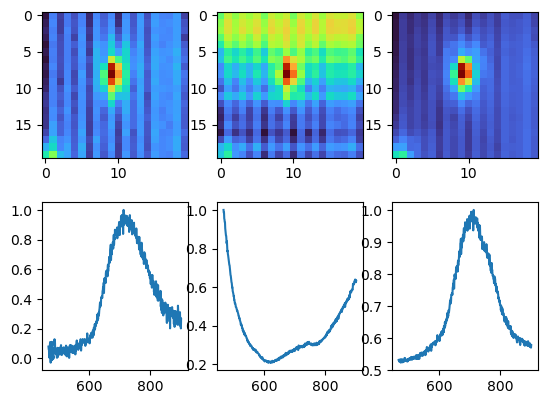

In [5]:
positions = np.loadtxt('data_from_2024-12-21/mg110_glyc_33/positions.txt')
npi = 0

xi = int(positions[npi,0])-1
yi = int(positions[npi,1])-1



fig, ax = plt.subplots(2,3)
specfin = (inten_raw - bkavg) / stanim
ax[0,0].imshow(np.sum(specfin,2).T[5:25,48:68], cmap='turbo')
ax[1,0].plot(wave_raw[100:], specfin[xi,yi,100:] / max(specfin[xi,yi,100:]), label='Full')


specfin = inten_raw / stanim
ax[0,1].imshow(np.sum(specfin,2).T[5:25,48:68], cmap='turbo')
ax[1,1].plot(wave_raw[100:], specfin[xi,yi,100:] / max(specfin[xi,yi,100:]), label='Divide by')

specfin = inten_raw 
ax[0,2].imshow(np.sum(specfin,2).T[5:25,48:68], cmap='turbo')
ax[1,2].plot(wave_raw[100:], specfin[xi,yi,100:] / max(specfin[xi,yi,100:]), label='Raw')




In [6]:
scaled = 1000
def fit_2Dgauss(M, a, x0, c1, y0, c2, d):
    x, y = M
    return 1E3*a*np.exp(-((x-x0)**2 / (2*(c1)**2) + (y-y0)**2 / (2*(c2)**2))) + d*scaled


In [7]:
def fit_the_NP_eachwave(specfin, waveidx, xi, yi):
    # Find the background at a given wavelength
    specfin = specfin[xi-10:xi+10, yi-10:yi+10, waveidx].T
    xrange = np.linspace(0, specfin.shape[0]-1, specfin.shape[0])
    yrange = np.linspace(0, specfin.shape[1]-1, specfin.shape[1])
    X, Y = np.meshgrid(xrange, yrange)
    xdata = np.vstack((X.ravel(), Y.ravel()))
    Z = specfin.ravel()
    p0 = [1., 10., 0.86, 10., 1., 2.]
    popt, pcov = curve_fit(fit_2Dgauss, xdata, Z, p0)
    fitdata = fit_2Dgauss(xdata, *popt).reshape(len(yrange), len(xrange))
    return specfin, fitdata, popt

In [8]:
wave_0 = 150
background = np.zeros((len(positions), (len(wave_raw)-wave_0)))

for NPi in range(len(positions)):
    npi = NPi
    xi = int(positions[npi,0])-1
    yi = int(positions[npi,1])-1
    
    for wavei in range(len(wave_raw)-wave_0):
        try:
            _, _, popt = fit_the_NP_eachwave(specfin=inten_raw, 
                                             waveidx=wavei+wave_0, 
                                             xi=int(positions[npi,0])-1, 
                                             yi=int(positions[npi,1])-1)
        except RuntimeError:
            pass
        background[NPi, wavei] = np.round(popt[-1]*scaled, 1)

/Users/clairewest/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [9]:
def fit_lorentz(wave_eV, A, Gam_eV, wave0_eV):
    return A * 0.5 * Gam_eV / ((wave_eV-wave0_eV)**2 + (0.5*Gam_eV)**2)

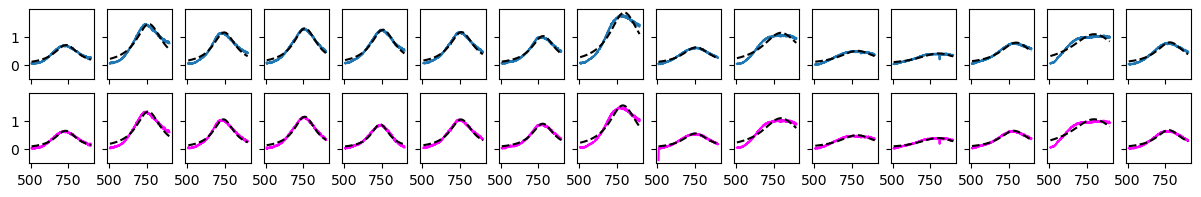

In [10]:
fig, ax = plt.subplots(2,15, figsize=[15,2],sharey=True, sharex=True)

gam_avg = np.zeros(len(positions))
eres_avg = np.zeros(len(positions))

gam_fit = np.zeros(len(positions))
eres_fit = np.zeros(len(positions))


for NPi in range(len(positions)):
    npi = NPi
    xi = int(positions[npi,0])-1
    yi = int(positions[npi,1])-1

    

    
    specfin_avgbkd = (inten_raw[:,:,wave_0:] - bkavg[wave_0:]) / stanim[:,:,wave_0:]
    sum3_avgbkd = np.round((specfin_avgbkd[xi+1,yi-1,:]+specfin_avgbkd[xi,yi-1,:]+specfin_avgbkd[xi-1,yi-1,:]+
                       specfin_avgbkd[xi+1,yi,:]+  specfin_avgbkd[xi,yi,:]+  specfin_avgbkd[xi-1,yi,:]+
                       specfin_avgbkd[xi+1,yi+1,:]+specfin_avgbkd[xi,yi+1,:]+specfin_avgbkd[xi-1,yi+1,:]), 5)
    ax[0,NPi].plot(wave_raw[wave_0:], sum3_avgbkd, label='Average Background')

    popt, pcov = curve_fit(fit_lorentz, wave_raw[wave_0:], sum3_avgbkd,
                            p0=[100,200,770])#, bounds=[[0,0.1,1],[1,0.5,3]])
    ax[0,NPi].plot(wave_raw[wave_0:], fit_lorentz(wave_raw[wave_0:], *popt), color='k', linestyle='--')
    gam_avg[npi] = popt[1]; eres_avg[npi] = popt[2]
    
    
    specfin_fitbkd = (inten_raw[:,:,wave_0:] - background[npi,:]) / stanim[:,:,wave_0:]
    sum3_fitbkd = np.round((specfin_fitbkd[xi+1,yi-1,:]+specfin_fitbkd[xi,yi-1,:]+specfin_fitbkd[xi-1,yi-1,:]+
                   specfin_fitbkd[xi+1,yi,:]+  specfin_fitbkd[xi,yi,:]+  specfin_fitbkd[xi-1,yi,:]+
                   specfin_fitbkd[xi+1,yi+1,:]+specfin_fitbkd[xi,yi+1,:]+specfin_fitbkd[xi-1,yi+1,:]), 5)

    ax[1,NPi].plot(wave_raw[wave_0:], sum3_fitbkd, color='magenta', label='Fit Background')
    popt, pcov = curve_fit(fit_lorentz, wave_raw[wave_0:], sum3_fitbkd,
                             p0=[100,200,770])#, bounds=[[0,0.1,1],[1,0.5,3]]) 

    ax[1,NPi].plot(wave_raw[wave_0:], fit_lorentz(wave_raw[wave_0:], *popt), color='k', linestyle='--')
    gam_fit[npi] = popt[1]; eres_fit[npi] = popt[2]

    
# # plt.legend()
# # ax[0,0].set_xlim([500,900]);

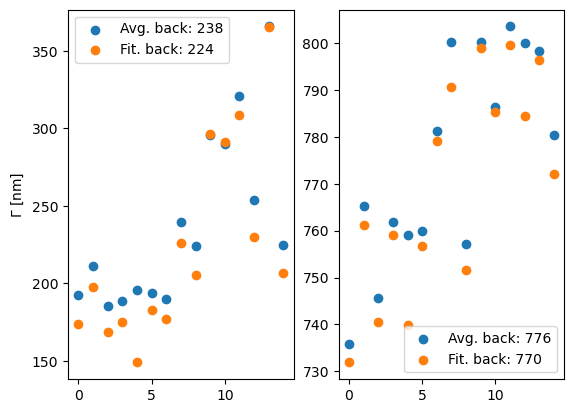

In [11]:
fig, ax = plt.subplots(1,2)


label=str('Avg. back: ')+str(int(np.round(np.mean(gam_avg))))#+ str(' +/- ') + str(int(np.round(np.std(gam_avg))))
ax[0].scatter(np.arange(0,15), gam_avg, label=label)

label=str('Fit. back: ')+str(int(np.round(np.mean(gam_fit))))#+ str(' +/- ') + str(int(np.round(np.std(gam_fit))))
ax[0].scatter(np.arange(0,15), gam_fit, label=label)

label=str('Avg. back: ')+str(int(np.round(np.mean(eres_avg))))#+ str(' +/- ') + str(int(np.round(np.std(eres_avg))))
ax[1].scatter(np.arange(0,15), eres_avg, label=label)

label=str('Fit. back: ')+str(int(np.round(np.mean(eres_fit))))#+ str(' +/- ') + str(int(np.round(np.std(eres_fit))))
ax[1].scatter(np.arange(0,15), eres_fit, label=label)

ax[0].set_ylabel('$\Gamma$ [nm]')

ax[0].legend()#frameon=False)
ax[1].legend()#frameon=False)

In [12]:
1240/.4

3100.0

In [13]:
x = np.array([736,765,746,762,759,760,781,800,757,799,786,802,800,796,780])
print(np.mean(x))

775.2666666666667


In [14]:
# ## Let's look at NP 1

# NPi = 19

# # Center NP pixel
# x = all_indmax[NPi][0]
# y = all_indmax[NPi][1]

# ### We actually will need to fit a Gaussian to each wavelength :/
# I_back = np.zeros(DFS_NPs_cropped.shape[-1])

# for wave_i in range(DFS_NPs_cropped.shape[-1]):
#     data_smallwind = DFS_NPs_cropped[x-5:x+5, y-5:y+5, wave_i]
#     try:
#         _, _, fitdata_i, _, popt_i, _, _ = find_the_NP(initial_data=data_smallwind)
#     except RuntimeError:
#         pass
#     I_back[wave_i] = popt_i[-1]*scaled
    
    
# DFS = DFS_NPs_cropped - I_back 





In [15]:



specfin = np.round((inten_raw - bkavg) / stanim,5)

specfin_reshp = specfin.reshape(261,103,670)


57 13


(500.0, 900.0)

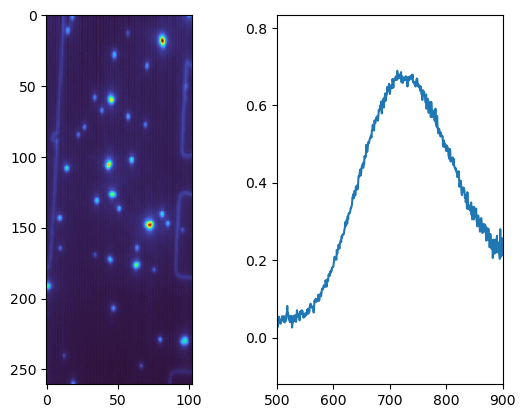

In [16]:
positions = np.loadtxt('data_from_2024-12-21/mg110_glyc_33/positions.txt')
npi = 0

xi = int(positions[npi,0])-1
yi = int(positions[npi,1])-1


print(xi,yi)
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.sum(specfin,2).T, cmap='turbo')
# ax[0].add_patch(plt.Circle([xi, yi], radius=7, edgecolor='r',lw=2, fill=False))        

sum_over_three = np.round((specfin[xi+1,yi-1,:]+specfin[xi,yi-1,:]+specfin[xi-1,yi-1,:]+
                           specfin[xi+1,yi,:]+  specfin[xi,yi,:]+  specfin[xi-1,yi,:]+
                           specfin[xi+1,yi+1,:]+specfin[xi,yi+1,:]+specfin[xi-1,yi+1,:]), 5)


ax[1].plot(wave_raw,sum_over_three,
           label='reprod. in python')


ax[1].set_xlim([500,900])

